# Explore and Analysis MEG & EEG Data

In [1]:
import sys
import os
import os.path as op
import numpy as np
import pandas as pd
sys.path.append("../")
from mne_path import PathHandler
ph = PathHandler()
from glob import glob
import random

import mne

%matplotlib inline

# Loading data

* MNE-Python package was created to work with Neuromag's FIF file format and data structures are based around the FIF file format from Neuromag, 

* Nevertheless, the package consists of reader functions for other data formats and to interface with many publicly available datasets

The downloaded `MNE-sample-data` contains EEG, MEG and structural MRI data from an audiovisual experiment performed on volunteers

This sample dataset selected for this analysis is `sample_audvis_filt-0-40_raw.fif` which has previously been filtered and downsampled.  The original raw data is `sample_audvis_raw.fif`.

In [2]:
SAMPLE_DATA_DIR = ph.cddir(ph.SAMPLE_DIR)

# list of all fif files in sample data
FIF_FILES = sorted(glob(op.join(SAMPLE_DATA_DIR, "**/**/*.fif")))

print("Total FIF Files: ", len(FIF_FILES))
display(FIF_FILES[:5])

Changed to:  /Users/jonghang/mne_data/MNE-sample-data
Total FIF Files:  36


['/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/all-trans.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/ernoise-cov.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/ernoise_raw-eve.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/ernoise_raw.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/sample_audvis-ave.fif']

## Select FIF Raw File for Analysis

In [3]:
sample_data_raw_file = FIF_FILES[26]
fif_raw = mne.io.read_raw_fif(sample_data_raw_file, preload = True)

Opening raw data file /Users/jonghang/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


Make 2 copies of `Raw` file, one is the original, another one for **Independent Component Analysis**.

__Projection Items__

The Projection Items above are SSP projectors calculated to remove environmental noise from the MEG signals, plus a projector to mean-reference the EEG channels.  Details of these projections will be discussed in the future. 

In addition to the information displayed during loading, you can get a glimpse of the basic details of a Raw object by printing it; even more is available by printing its info attribute (a dictionary-like object that is preserved across Raw, Epochs, and Evoked objects). 

The info data structure keeps track of channel locations, applied filters, projectors, etc. Notice especially the chs entry, showing that MNE-Python detects different sensor types and handles each appropriately

# Independent Component Analysis (ICA)

The `mne.preprocessing` and `mne.filter` consists of a variety of tools for preprocessing such as maxwell filtering, signal-space projection, ICA, downsampling and much more.

## ICA Implementations
There are 4 ICA implementations in MNE package:

In [4]:
ICA_METHOD_FAST_ICA = "fastica"
ICA_METHOD_PICARD = "picard"
ICA_METHOD_INFOMAX = "infomax"
ICA_METHOD_INFOMAX_EXT = "extended-infomax"

## Configure ICA

In [5]:
def get_ica(input_n_components, 
            ica_method = ICA_METHOD_FAST_ICA): 
    """
    Fit FIF raw data into ICA using fast ICA if 
    method is not specified
    """
    fifica = mne.preprocessing.ICA(n_components = input_n_components, 
                                    method = ica_method,
                                    random_state = 13, 
                                    max_iter = 800)
    return fifica

## Use ICA to Clean FIF Raw
### Filter FIF Raw with 1 Hz High Pass

In [6]:
fif_raw.filter(1.0, None, n_jobs = 1, fir_design = 'firwin')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 497 samples (3.310 sec)



<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.8 MB, data loaded>

### Apply ICA to Clean Data

In [7]:
fif_ica = get_ica(input_n_components = 25,
                  ica_method = ICA_METHOD_FAST_ICA)

# Fit FIF Raw with ICA
fif_ica.fit(fif_raw.copy())

# Exclude the first component
fif_ica.exclude = [1]

fif_raw_cleaned = fif_ica.apply(fif_raw.copy())

display(fif_raw_cleaned)

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 3.8s.
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 364 PCA components


<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.8 MB, data loaded>

## Plot to Compare Time Series Before and After ICA-Cleaned
### Before Applying ICA

Using matplotlib as 2D backend.


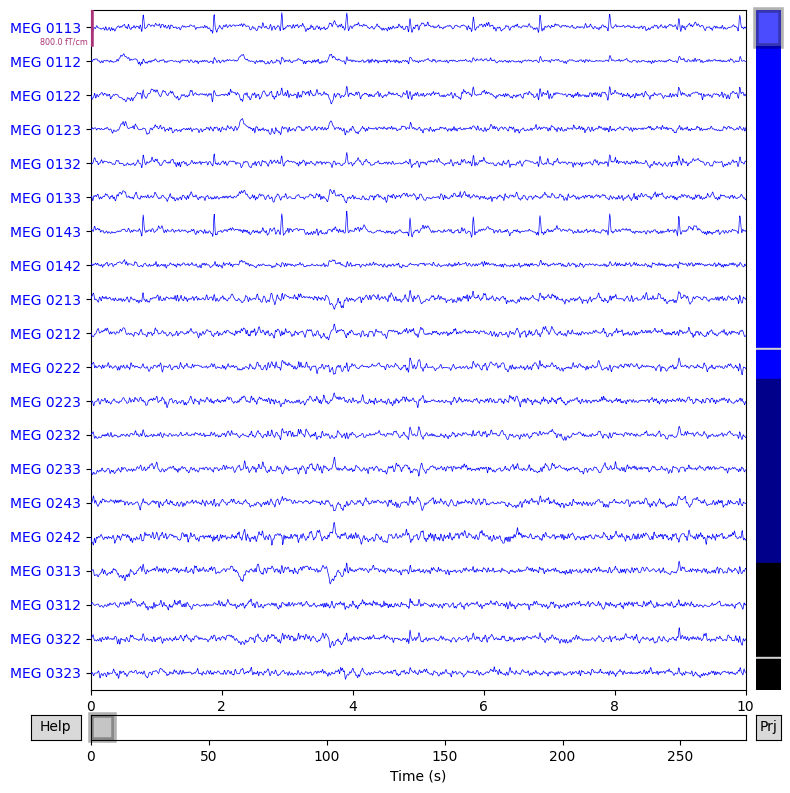

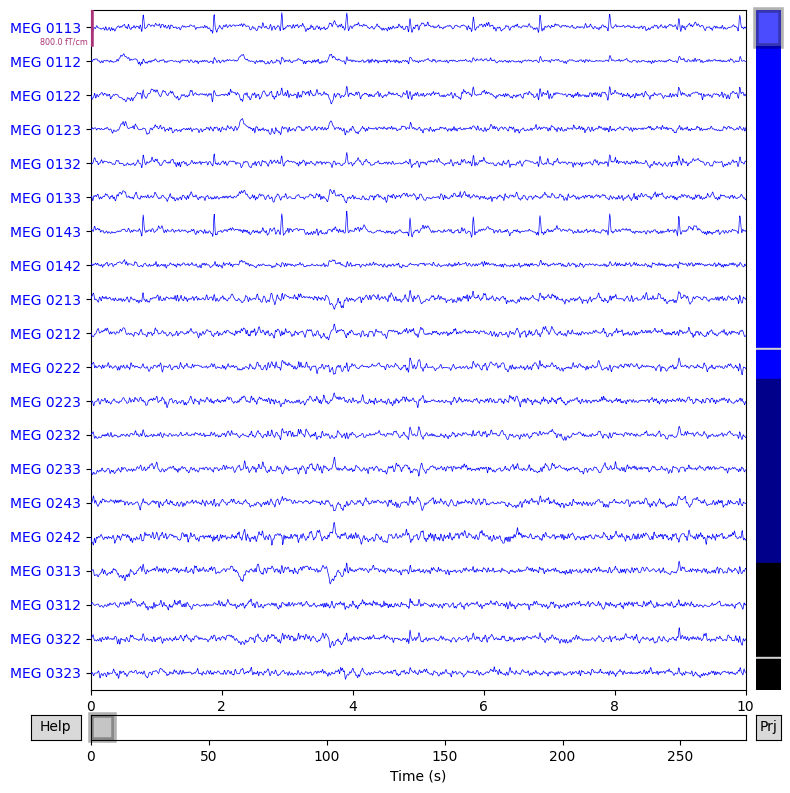

In [8]:
fif_raw.plot()

### After Applying ICA

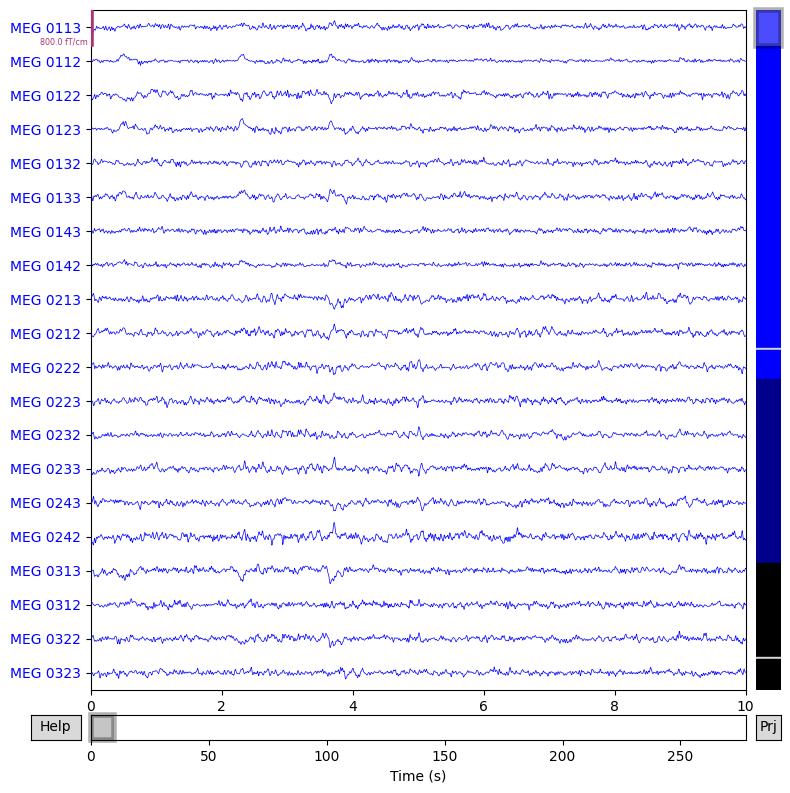

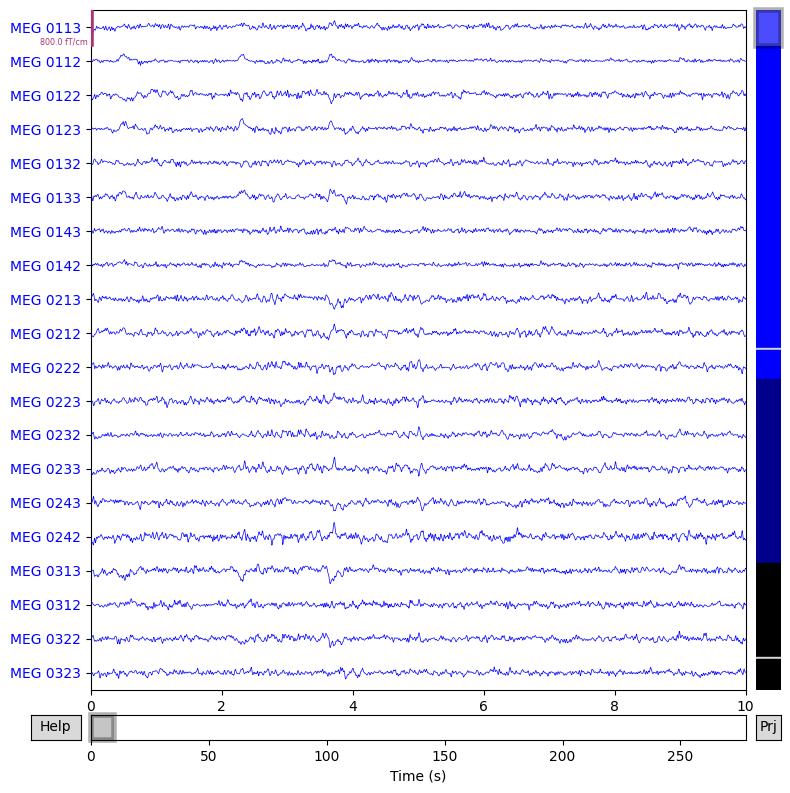

In [9]:
fif_raw_cleaned.plot()

## Plot to Compare Before and After ICA on Frontal

In [15]:
fif_ica = get_ica(input_n_components = 25,
                  ica_method = ICA_METHOD_FAST_ICA)

# Fit FIF Raw with ICA
fif_ica.fit(fif_raw.copy())

# Exclude the first component
fif_ica.exclude = [1]

fif_raw_cleaned = fif_ica.apply(fif_raw.copy())

display(fif_raw_cleaned)

# Select frontal channels to demonstrate more dramatic removal
SELECTED_CHS = ['MEG 0111', 'MEG 0121', 'MEG 0131', 'MEG 0211', 'MEG 0221', 'MEG 0231', 'MEG 0311', 'MEG 0321', 
                'MEG 0331', 'MEG 1511', 'MEG 1521', 'MEG 1531', 'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 
                'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008']

# get the channel indices
frontal_channels = [fif_raw.ch_names.index(ch) for ch in SELECTED_CHS]

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 3.0s.
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 364 PCA components


<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.8 MB, data loaded>

### Plot Frontal Channels Before ICA Cleaning

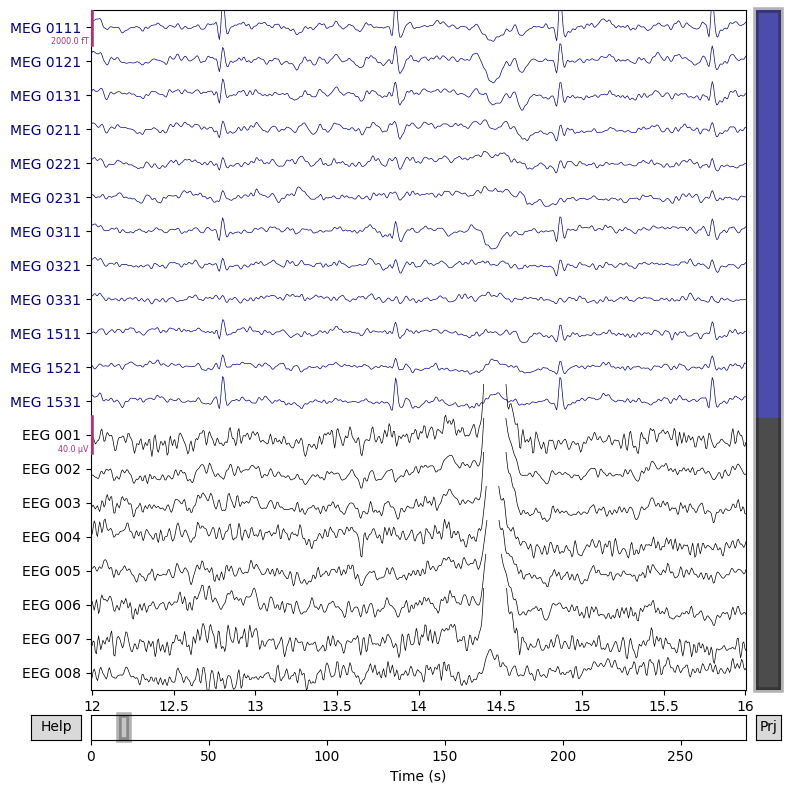

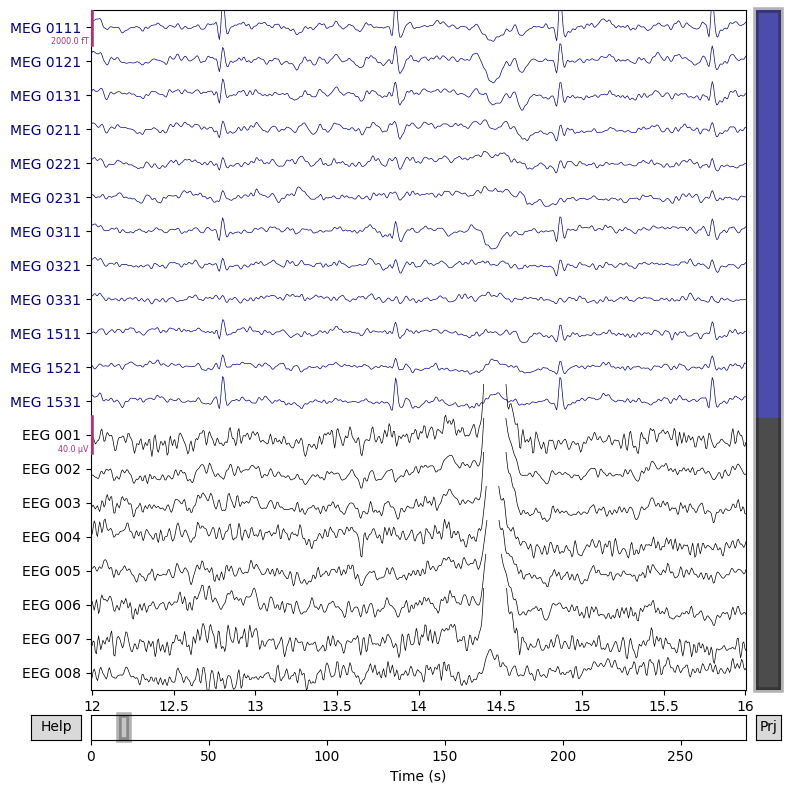

In [16]:
fif_raw.plot(order = frontal_channels,
            start = 12, duration = 4)

### Plot Frontal Channels After ICA Cleaning

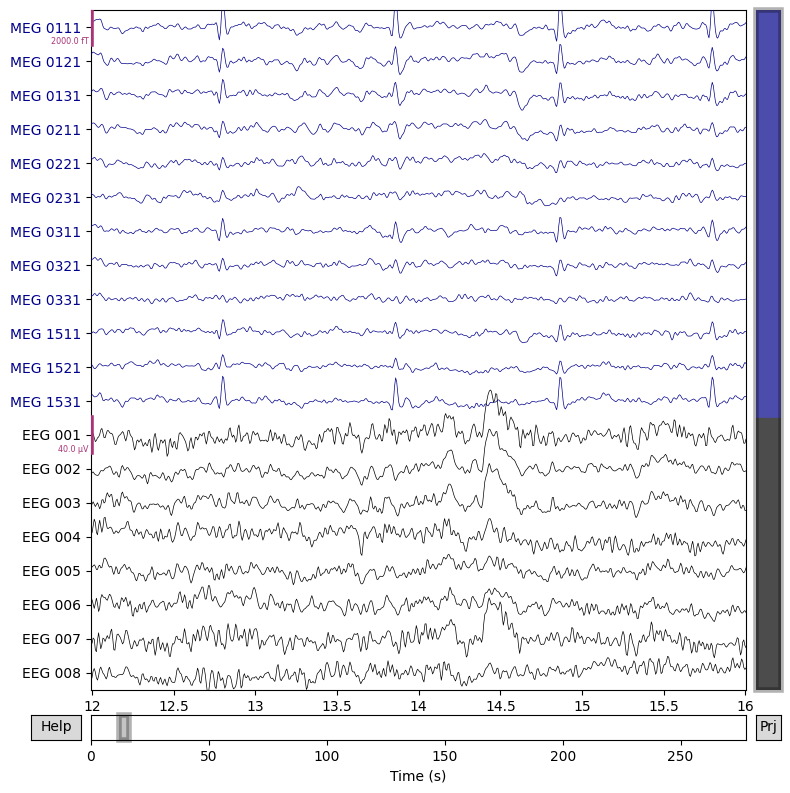

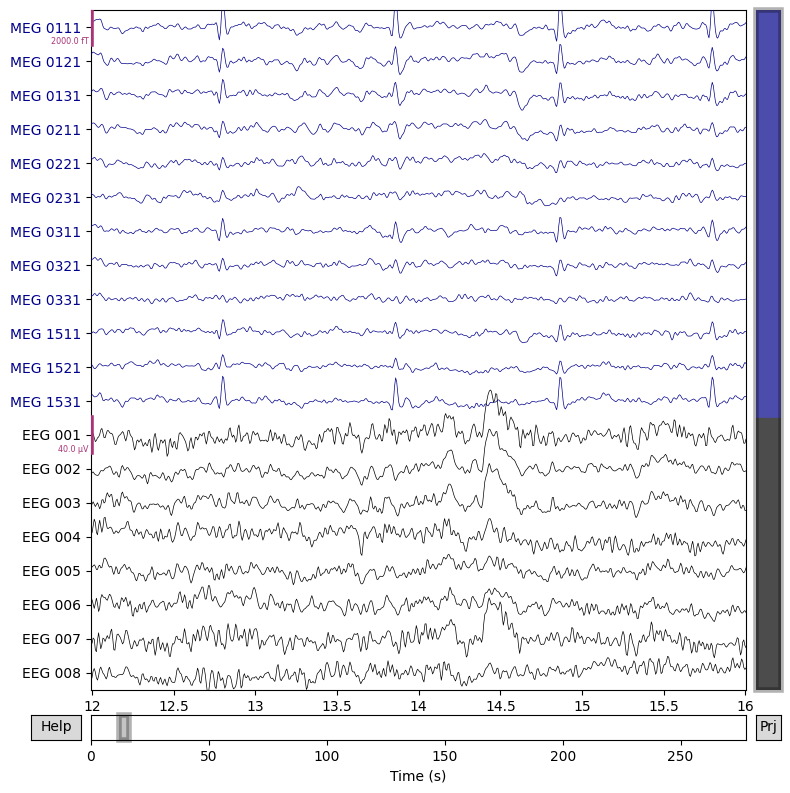

In [17]:
fif_raw_cleaned.plot(order = frontal_channels,
                    start = 12, duration = 4)

## Select EEG and MEG Channel Types
### Reject Criteria

In [10]:
reject_criteria = dict(mag = 3000e-15,     # 3000 fT
                       grad = 3000e-13,    # 3000 fT/cm
                       eeg = 100e-6,       # 100 µV
                       eog = 200e-6)       # 200 µV

### Fit ICA and Plot Components

In [11]:
def fit_ica_plot_components(input_ica, picked_ch):

    # decim : Increment for selecting 
    #         only each n-th sampling point
    input_ica.fit(fif_raw.copy(), 
                  picks = picked_ch, 
                  decim = 2,
                  reject = reject_criteria);

    # Plot components
    fif_ica.plot_components();

## Analyze and Plot MEG Components

Fitting ICA to data using 305 channels (please be patient, this may take a while)
    Rejecting  epoch based on MAG : ['MEG 0111']
Artifact detected in [151, 302]
    Rejecting  epoch based on MAG : ['MEG 1421']
Artifact detected in [604, 755]
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 0121', 'MEG 0141', 'MEG 0511', 'MEG 1411', 'MEG 1421']
Artifact detected in [1057, 1208]
    Rejecting  epoch based on MAG : ['MEG 1421', 'MEG 1431', 'MEG 1741', 'MEG 2141']
Artifact detected in [1208, 1359]
    Rejecting  epoch based on MAG : ['MEG 1431', 'MEG 2131', 'MEG 2141']
Artifact detected in [1359, 1510]
    Rejecting  epoch based on MAG : ['MEG 1421']
Artifact detected in [1661, 1812]
    Rejecting  epoch based on MAG : ['MEG 2131', 'MEG 2541']
Artifact detected in [1963, 2114]
    Rejecting  epoch based on MAG : ['MEG 1421']
Artifact detected in [2114, 2265]
    Rejecting  epoch based on MAG : ['MEG 0111', 'MEG 1411', 'MEG 1421', 'MEG 2131', 'MEG 2541']
Artifact detected in [2265, 2

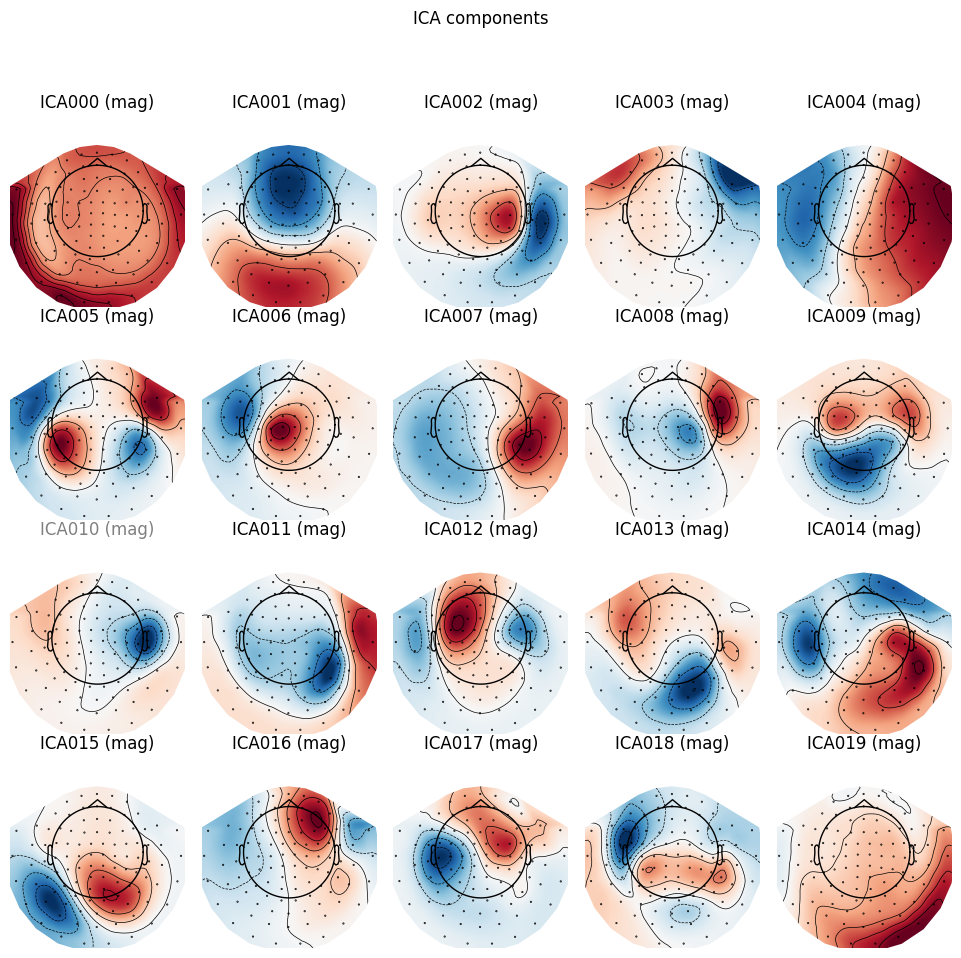

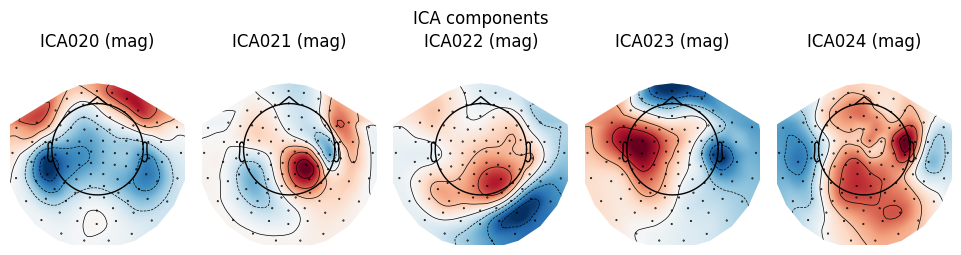

In [12]:
# Pick only MEG types to fit ICA
pick_types_MEG = mne.pick_types(fif_raw.copy().info,
                               meg = True, # select MEG
                               eeg = False, 
                               eog = False,
                               stim = False, 
                               exclude = 'bads')

fit_ica_plot_components(input_ica = fif_ica, 
                        picked_ch = pick_types_MEG)

## Analyze and Plot EEG Components

Fitting ICA to data using 59 channels (please be patient, this may take a while)
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 006', 'EEG 007', 'EEG 015']
Artifact detected in [0, 151]
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 010', 'EEG 015']
Artifact detected in [151, 302]
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 018', 'EEG 019', 'EEG 020', 'EEG 021', 'EEG 022', 'EEG 023', 'EEG 024', 'EEG 031', 'EEG 032', 'EEG 033', 'EEG 034', 'EEG 035', 'EEG 041', 'EEG 042']
Artifact detected in [1057, 1208]
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG

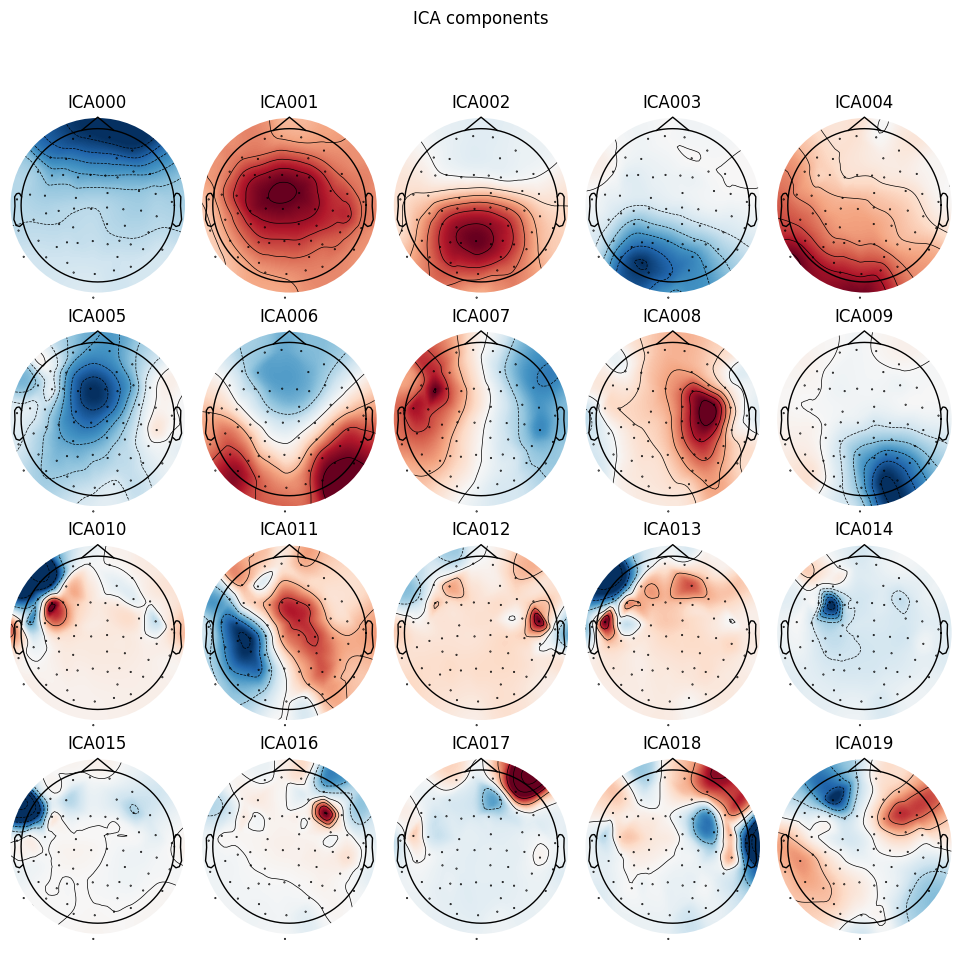

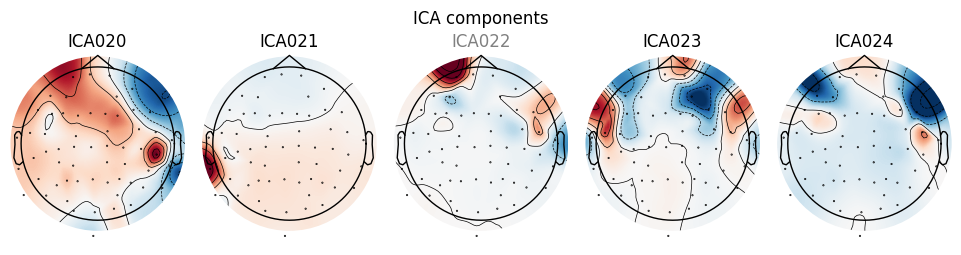

In [13]:
pick_types_EEG = mne.pick_types(fif_raw.info,
                               meg = False, 
                               eeg = True, # select EEG
                               eog = False,
                               stim = False, 
                               exclude = 'bads')

fit_ica_plot_components(input_ica = fif_ica, 
                        picked_ch = pick_types_EEG)

## Plot Properties with Specific Exclusion

Opening raw data file /Users/jonghang/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 2.8s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


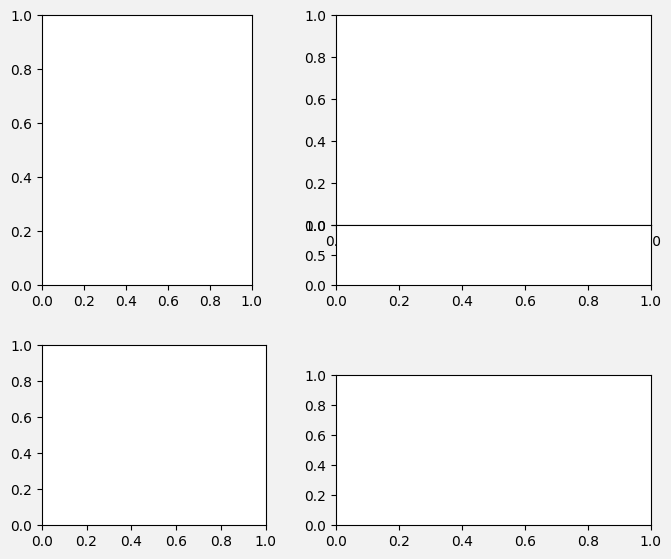

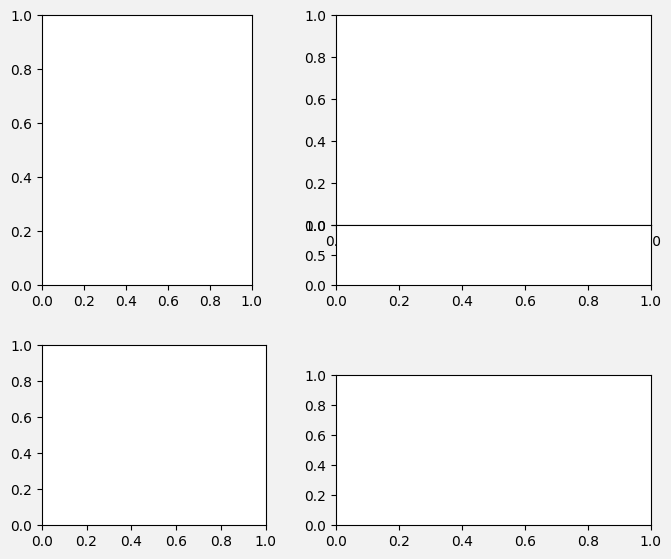

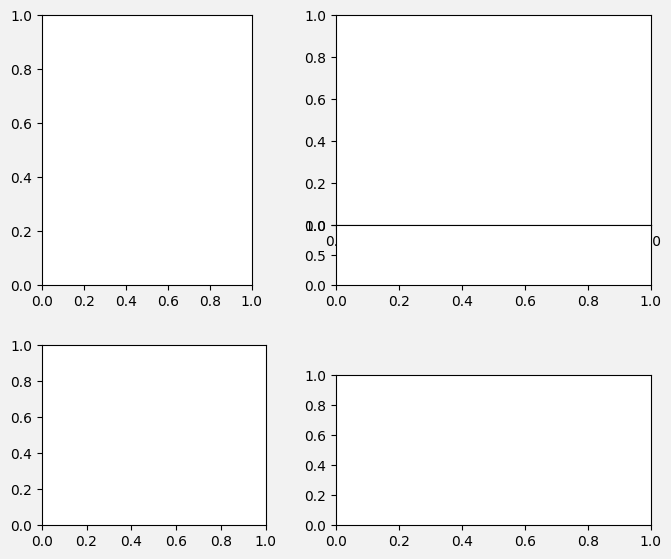

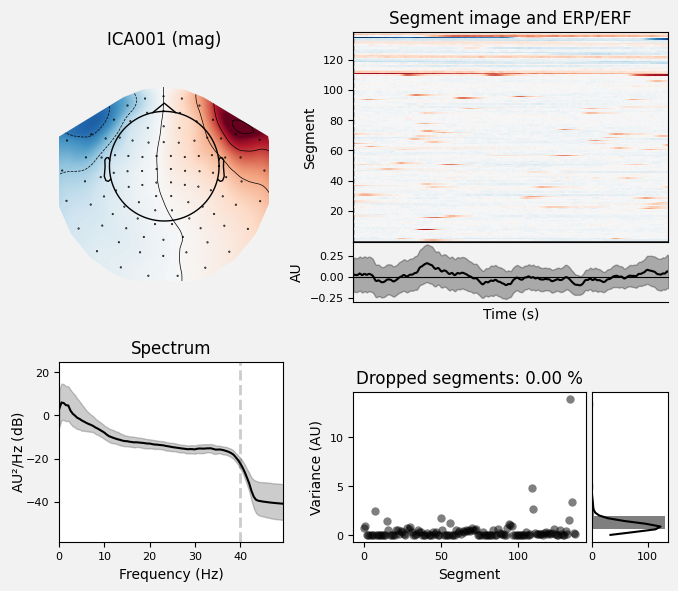

[<Figure size 700x600 with 6 Axes>]

In [18]:
# Read the FIF file anew
fif_raw = mne.io.read_raw_fif(sample_data_raw_file, preload = True)

fif_ica2 = get_ica(input_n_components = 25,
                  ica_method = ICA_METHOD_FAST_ICA)

# Fit FIF Raw with ICA
fif_ica2.fit(fif_raw.copy())

# plot properties
fif_ica.exclude = [1]
fif_ica2.plot_properties(fif_raw.copy(), picks = fif_ica.exclude)

### Plot Properties of 10th Component

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


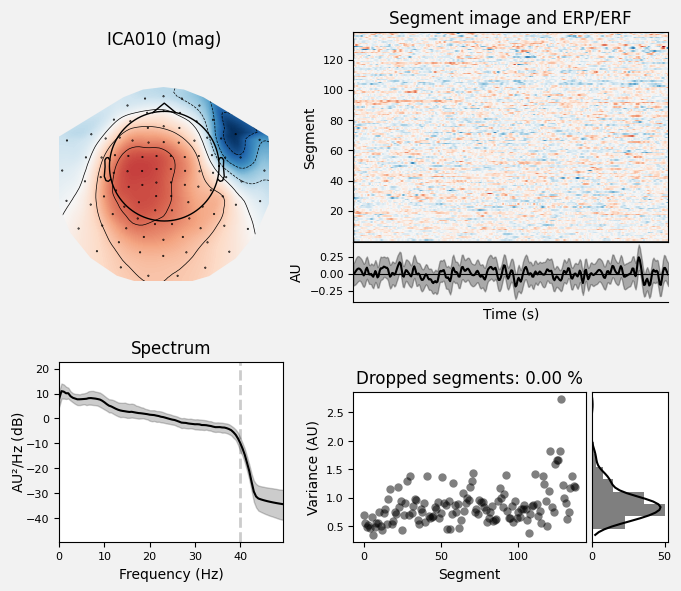

[<Figure size 700x600 with 6 Axes>]

In [22]:
# pick a single component
fif_ica2.plot_properties(fif_raw.copy(), picks = 10)

### Plot Properties of 20th Components

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


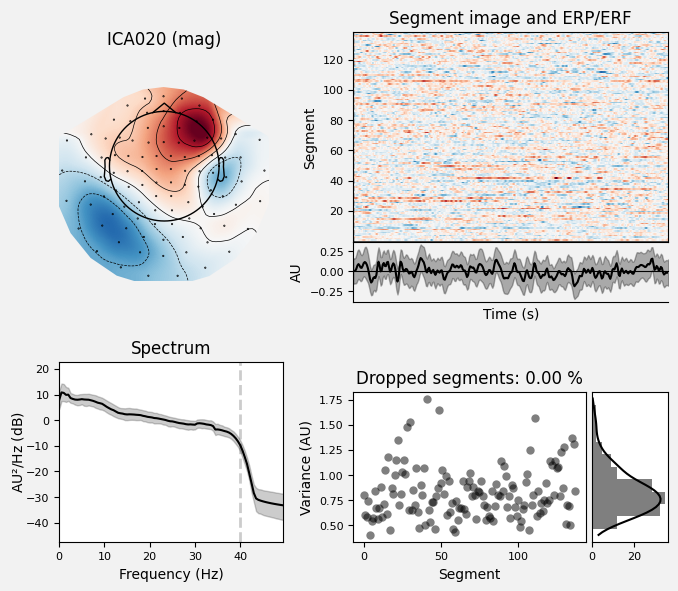

[<Figure size 700x600 with 6 Axes>]

In [23]:
fif_ica2.plot_properties(fif_raw.copy(), picks = 20)

In [18]:
help(fif_raw.plot)

Help on method plot in module mne.io.base:

plot(events=None, duration=10.0, start=0.0, n_channels=20, bgcolor='w', color=None, bad_color='lightgray', event_color='cyan', scalings=None, remove_dc=True, order=None, show_options=False, title=None, show=True, block=False, highpass=None, lowpass=None, filtorder=4, clipping=1.5, show_first_samp=False, proj=True, group_by='type', butterfly=False, decim='auto', noise_cov=None, event_id=None, show_scrollbars=True, show_scalebars=True, time_format='float', precompute=None, use_opengl=None, *, theme=None, overview_mode=None, verbose=None) method of mne.io.fiff.raw.Raw instance
    Plot raw data.
    
    Parameters
    ----------
    events : array | None
        Events to show with vertical bars.
    duration : float
        Time window (s) to plot. The lesser of this value and the duration
        of the raw file will be used.
    start : float
        Initial time to show (can be changed dynamically once plotted). If
        show_first_samp i